In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import sklearn as sk
from sklearn.model_selection import TimeSeriesSplit

In [406]:
# Download the data from Yahoo Finance (^SOX and ^VIX)
start_date='2014-12-23'
end_date='2024-01-11'

data = yf.download('^SOX ^VIX', start=start_date, end=end_date, interval='1d')['Close']
data.index = pd.to_datetime(data.index)
data['^VIX^2'] = data['^VIX'].pow(2)

# Calculate the log returns
data['^SOX: Log_Returns'] = np.log(data['^SOX'].pct_change() + 1)
data['^VIX: Log_Returns'] = np.log(data['^VIX'].pct_change() + 1)
data['^VIX^2: Log_Returns'] = np.log(data['^VIX^2'].pct_change() + 1)

# Calculate the backward/forward realized volatility (Weekly RV stands for the 5-day realized volatility)
data['^SOX: Weekly_RV'] = np.sqrt((data['^SOX: Log_Returns']**2).rolling(5).sum())
data['^SOX: Next_Weekly_RV'] = np.sqrt((data['^SOX: Log_Returns']**2).rolling(5).sum()).shift(-6)
data = data.dropna()
data.describe()

[*********************100%%**********************]  2 of 2 completed

Ticker,^SOX,^VIX,^VIX^2,^SOX: Log_Returns,^VIX: Log_Returns,^VIX^2: Log_Returns,^SOX: Weekly_RV,^SOX: Next_Weekly_RV
count,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000
mean,1883.986029,18.562855,401.328807,0.000777,-0.000083,-0.000165,0.037733,0.037784
std,1043.253024,7.534870,450.160733,0.019630,0.079731,0.159462,0.022427,0.022411
min,559.179993,9.140000,83.539606,-0.173119,-0.299831,-0.599662,0.003846,0.003846
25%,999.342514,13.370000,178.756897,-0.009083,-0.046165,-0.092329,0.023026,0.023123
50%,1473.589966,16.719999,279.558377,0.001420,-0.007235,-0.014470,0.032805,0.032884
75%,2954.464905,21.835000,476.767302,0.011343,0.035741,0.071482,0.047945,0.047994
max,4214.589844,82.690002,6837.636504,0.105753,0.768245,1.536490,0.271085,0.271085


In [407]:
data.head(10)

Ticker,^SOX,^VIX,^VIX^2,^SOX: Log_Returns,^VIX: Log_Returns,^VIX^2: Log_Returns,^SOX: Weekly_RV,^SOX: Next_Weekly_RV
Date,,,,,,,,
2014-12-31,686.869995,19.200001,368.640029,-0.005980,0.187334,0.374668,0.009015,0.042248
2015-01-02,686.729980,17.790001,316.484133,-0.000204,-0.076274,-0.152548,0.008895,0.042652
2015-01-05,673.590027,19.920000,396.806403,-0.019320,0.113088,0.226175,0.021248,0.037622
2015-01-06,658.830017,21.120001,446.054435,-0.022156,0.058496,0.116992,0.030574,0.036822
2015-01-07,665.270020,19.309999,372.876079,0.009727,-0.089597,-0.179195,0.031537,0.024333
2015-01-08,684.650024,17.010000,289.340108,0.028715,-0.126822,-0.253643,0.042230,0.026729
2015-01-09,685.520020,17.549999,308.002473,0.001270,0.031252,0.062505,0.042248,0.020201
2015-01-12,671.820007,19.600000,384.160015,-0.020187,0.110476,0.220951,0.042652,0.021158
2015-01-13,665.580017,20.559999,422.713578,-0.009332,0.047818,0.095636,0.037622,0.021282


In [408]:
data.tail(10)

Ticker,^SOX,^VIX,^VIX^2,^SOX: Log_Returns,^VIX: Log_Returns,^VIX^2: Log_Returns,^SOX: Weekly_RV,^SOX: Next_Weekly_RV
Date,,,,,,,,
2023-12-18,4103.790039,12.56,157.753611,-0.003214,0.022545,0.045091,0.031821,0.043829
2023-12-19,4125.560059,12.53,157.000893,0.005291,-0.002391,-0.004783,0.031467,0.032898
2023-12-20,4007.659912,13.67,186.868902,-0.028994,0.087078,0.174156,0.039943,0.019990
2023-12-21,4118.589844,13.65,186.322490,0.027303,-0.001464,-0.002928,0.040584,0.042079
2023-12-22,4132.850098,13.03,169.780893,0.003456,-0.046485,-0.092970,0.040453,0.043277
2023-12-26,4207.450195,12.99,168.740094,0.017890,-0.003075,-0.006149,0.044115,0.044023
2023-12-27,4214.589844,12.43,154.504908,0.001695,-0.044067,-0.088134,0.043829,0.044447
2023-12-28,4208.680176,12.47,155.500907,-0.001403,0.003213,0.006426,0.032898,0.054350
2023-12-29,4175.470215,12.45,155.002495,-0.007922,-0.001605,-0.003210,0.019990,0.039638


In [409]:
# rename the columns (delete special characters)
data = data.rename(columns=lambda x: x.replace('^', '').replace(':', ''))
data.columns

Index(['SOX', 'VIX', 'VIX2', 'SOX Log_Returns', 'VIX Log_Returns',
       'VIX2 Log_Returns', 'SOX Weekly_RV', 'SOX Next_Weekly_RV'],
      dtype='object', name='Ticker')

### Data Preprocessing
1. Wisnorization
2. Min Max Scaling

In [410]:
# transform numerical data with wisnorization
from scipy.stats.mstats import winsorize
data = pd.DataFrame(winsorize(np.array(data), limits=[0.05, 0.05]), columns=data.columns, index=data.index)
data.describe()

Ticker,SOX,VIX,VIX2,SOX Log_Returns,VIX Log_Returns,VIX2 Log_Returns,SOX Weekly_RV,SOX Next_Weekly_RV
count,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000
mean,1464.729576,18.562855,383.969143,0.000849,0.004370,0.023803,0.037733,0.037784
std,521.102128,7.534870,314.341449,0.019212,0.072659,0.131257,0.022427,0.022411
min,559.179993,9.140000,83.539606,-0.079010,-0.079010,-0.079010,0.003846,0.003846
25%,999.342514,13.370000,178.756897,-0.009083,-0.046165,-0.079010,0.023026,0.023123
50%,1473.589966,16.719999,279.558377,0.001420,-0.007235,-0.014470,0.032805,0.032884
75%,1998.089966,21.835000,476.767302,0.011343,0.035741,0.071482,0.047945,0.047994
max,1998.089966,82.690002,1998.089966,0.105753,0.768245,1.536490,0.271085,0.271085


In [411]:
# transform numerical data with min-max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
data.describe()

Ticker,SOX,VIX,VIX2,SOX Log_Returns,VIX Log_Returns,VIX2 Log_Returns,SOX Weekly_RV,SOX Next_Weekly_RV
count,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000
mean,0.629330,0.128115,0.156919,0.432224,0.098411,0.063641,0.126804,0.126996
std,0.362151,0.102446,0.164186,0.103983,0.085758,0.081248,0.083920,0.083860
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.305900,0.057512,0.049734,0.378468,0.038767,0.000000,0.071771,0.072134
50%,0.635488,0.103059,0.102384,0.435315,0.084715,0.039951,0.108365,0.108661
75%,1.000000,0.172604,0.205389,0.489020,0.135438,0.093155,0.165019,0.165201
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [412]:
# Create a pipeline to transform the data (winsozation and min-max scaling)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

def winsorize_data(data):
    return winsorize(np.array(data), limits=[0.05, 0.05])

def min_max_scale_data(data):
    return scaler.fit_transform(data)

def data_preprocess_transform(data):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', FunctionTransformer(winsorize_data), data.columns),
            ('num2', FunctionTransformer(min_max_scale_data), data.columns)
        ])
    data_tmp = preprocessor.fit_transform(data)
    return pd.DataFrame(data_tmp[:, -1*len(data.columns):], columns=data.columns, index=data.index)

### Training and Testing Dataset Preparation
1. Training Data : 2015-2022
2. Testing Data: 2023

In [413]:
# Split the data into training and test sets (training data from 2015 to 2020, test data from 2021 to 2022)
data_train = data.loc['2015-01-01':'2022-12-31']
data_test = data.loc['2023-01-01':'2023-12-31']

### Base Model Attributes(X) and Target(Y)
1. X \
    1.1 Index Value: ^SOX, ^VIX \
    1.2 Square Value: ^VIX^2 \
    1.3 Log Return: ^SOX, ^VIX, ^VIX^2
    
2. y: Weekly Relative Volatility of ^SOX

In [414]:
# Split the data into features and target
X_base_train = data_train.drop(columns=['SOX Next_Weekly_RV'])
y_train = data_train[['SOX Next_Weekly_RV']]
X_base_test = data_test.drop(columns=['SOX Next_Weekly_RV'])
y_test = data_test[['SOX Next_Weekly_RV']]

### Benchmark Model Training and Performance
1. Decesion Tree Regressor
2. Linear Regression

performance matrix
1. Root Mean Square Error
2. R-square

In [415]:
# Create a decision tree regressor model and use parameters from the grid search
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor(random_state=42)
model.fit(X_base_train, y_train)

param_grid = {
    'max_depth': range(1, 5),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(3, 8),
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=-1)
grid_search.fit(X_base_train, y_train)

# Report the best model parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score: 0.07863033470499442


In [417]:
# Predict the target variable for the test set and calculate the RMSE and R2 score
from sklearn.metrics import mean_squared_error, r2_score

model = grid_search.best_estimator_
y_pred = model.predict(X_base_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 score: {r2}")

RMSE: 0.06368739212606504
R2 score: -0.6238201477542931


In [418]:
# Create a linear regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_base_train, y_train)

LinearRegression()

In [419]:
# Predict the target variable for the test set and calculate the RMSE and R2 score
y_pred = model.predict(X_base_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 score: {r2}")

RMSE: 0.051648832771334
R2 score: -0.0679526963863013


### LightGBM Model Training and Performance
Hyperparamter tuning: Optuna

Time series split = 5

Objective function: Mean(Root Mean Squared Error)

Performance matrix:
1. Root Mean Squared Error
2. R-square
3. Root Mean Squared Percentage Error

Reference:\
https://forecastegy.com/posts/how-to-use-optuna-to-tune-lightgbm-hyperparameters/

In [450]:
# Clear the model result
model_result = model_result.iloc[0:0]

In [451]:
model_result = pd.DataFrame(columns=['Name', 'Stydy', 'Model', 'RMSE', 'R2', 'RMSPE'])

In [452]:
tscv = TimeSeriesSplit(n_splits=5)

In [453]:
import lightgbm as lgb
import optuna

def objective(trial, X, y):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": 200,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**4),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "gamma": trial.suggest_int("gamma", 5, 20),
    }

    rmse_scores = np.array([])
    model = lgb.LGBMRegressor(**params)

    for train_index, val_index in tscv.split(X):
        # print("TRAIN:", train_index, "TEST:", val_index)
        X_t, X_val = X.iloc[train_index], X.iloc[val_index]
        y_t, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_t, y_t)
        predictions = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, predictions))
        rmse_scores = np.append(rmse_scores, rmse)
    return rmse_scores.mean()

In [454]:
def lightgbm_train_performance(model_name, bool_new_data, new_features_data):
    # Split the data into training and test sets (training data from 2015 to 2020, test data from 2021 to 2022)
    if bool_new_data:
        data_train = pd.concat([data, new_features_data], axis=1).loc['2015-01-01':'2022-12-31'].dropna()
        data_test = pd.concat([data, new_features_data], axis=1).loc['2023-01-01':'2023-12-31'].dropna()
    else:
        data_train = data.loc['2015-01-01':'2022-12-31'].dropna()
        data_test = data.loc['2023-01-01':'2023-12-31'].dropna()

    # Create X and y
    X_train = data_train.drop(columns=['SOX Next_Weekly_RV'])
    y_train = data_train[['SOX Next_Weekly_RV']]
    X_test = data_test.drop(columns=['SOX Next_Weekly_RV'])
    y_test = data_test[['SOX Next_Weekly_RV']]
    
    sampler = optuna.samplers.TPESampler(seed=10)
    study = optuna.create_study(sampler=sampler, direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=30)
    
    # Create a LightGBM model with the best parameters
    best_params = study.best_params
    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, y_train)

    # Predict the target variable for the test set and calculate the RMSE, R2 score and RMSPE
    y_pred = model.predict(X_train)
    # plot the prediction and the actual values for training set
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='Target Volatility')
    plt.plot(y_train.index, y_pred, label='Forecast Volatility')
    plt.legend()
    plt.show()

    # Predict the target variable for the test set and calculate the RMSE, R2 score and RMSPE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmspe = np.sqrt(np.mean(np.square((y_test.squeeze() - y_pred.squeeze()) / y_test.squeeze())))

    # print(f"RMSE: {rmse}")
    # print(f"R2 score: {r2}")

    # plot the prediction and the actual values
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test, label='Target Volatility')
    plt.plot(y_test.index, y_pred, label='Forecast Volatility')
    plt.legend()
    plt.show()

    model_result.loc[len(model_result)] = ['LightGBM_'+model_name, study, model, rmse, r2, rmspe]    

[I 2024-04-27 22:06:27,380] A new study created in memory with name: no-name-91b097e5-368b-4623-8f72-c21b75966f10
[I 2024-04-27 22:06:27,646] Trial 0 finished with value: 0.08505228287282043 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.08505228287282043.
[I 2024-04-27 22:06:27,891] Trial 1 finished with value: 0.08270221223846255 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 1 with value: 0.08270221223846255.
[I 2024-04-27 22:06:28,078] Trial 2 finished with value: 0.0850262989043702 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2014, number of used features: 7
[LightGBM] [Info] Start training from score 0.126967
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


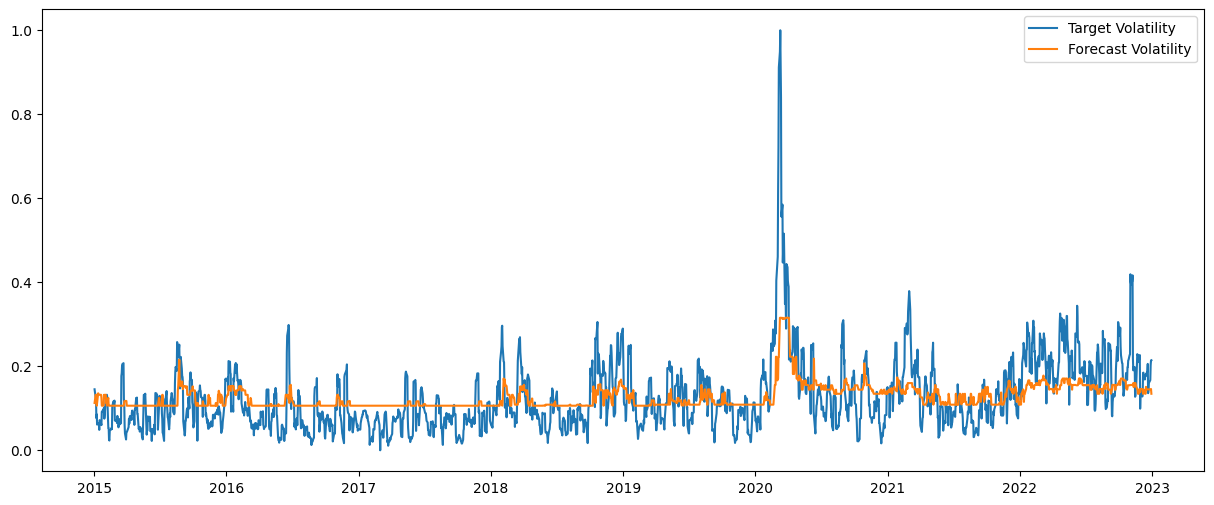

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


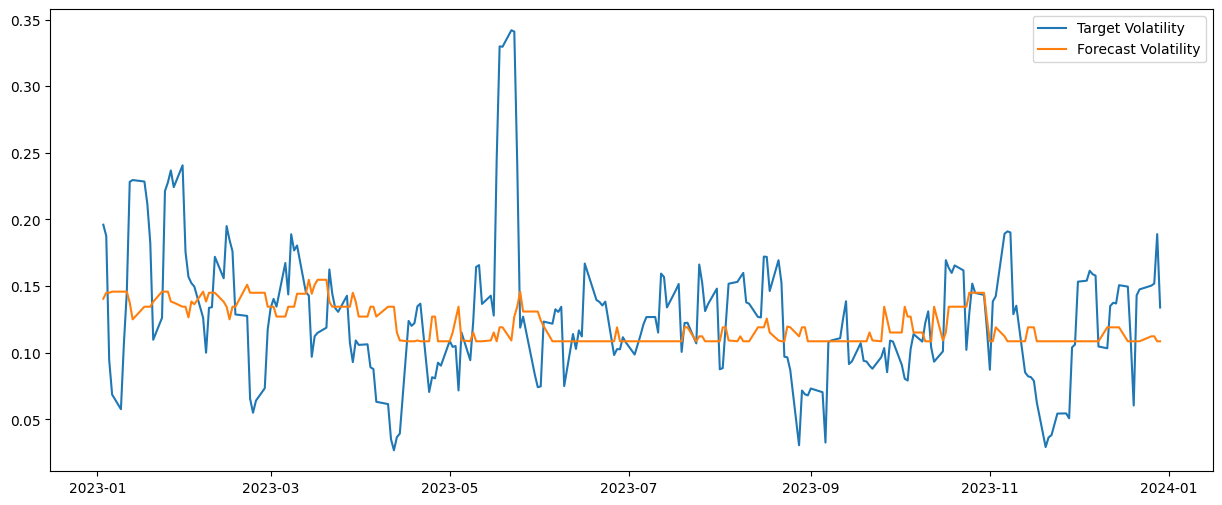

In [455]:
lightgbm_train_performance('Baseline', False, None)

### Feature Engineering
Y Lagged
1. lag weekly realized volatility
2. log of lag weekly realized volatility
3. square of lag weekly realized volatility

Non Linear VIX
1. log of VIX
2. log of past x days VIX

SOX Spread
1. SOX High-Low Spread
2. SOX Open-Close Spread

Technical Analysis
1. Bollinger Bands of SOX
2. Average True Range of SOX

In [456]:
# Replace the values of 'SOX Weekly_RV' less than 0.0001 with 0.0001 to prevent the log transformation from returning -inf
data.loc[data['SOX Weekly_RV'] <= 0.0001, 'SOX Weekly_RV'] = 0.0001

data_lag = pd.DataFrame()
for i in range(0, 15):
    # Add new columns name 'SOX Weekly_RV Lag' (14 periods lag)
    data_lag[f'SOX Weekly_RV Lag {i}'] = data['SOX Weekly_RV'].shift(i)
    # Add new columns name 'SOX Weekly_Log_RV Lag' (14 periods lag)
    data_lag[f'SOX Weekly_Log_RV Lag {i}'] = np.log(data['SOX Weekly_RV']).shift(i)
    # Add new columns name 'SOX Weekly_Squared_RV Lag' (14 periods lag)
    data_lag[f'SOX Weekly_Squared_RV Lag {i}'] = (data['SOX Weekly_RV']**2).shift(i)

data_lag = data_preprocess_transform(data_lag.dropna())
data_lag

,SOX Weekly_RV Lag 0,SOX Weekly_Log_RV Lag 0,SOX Weekly_Squared_RV Lag 0,SOX Weekly_RV Lag 1,SOX Weekly_Log_RV Lag 1,SOX Weekly_Squared_RV Lag 1,SOX Weekly_RV Lag 2,SOX Weekly_Log_RV Lag 2,SOX Weekly_Squared_RV Lag 2,SOX Weekly_RV Lag 3,...,SOX Weekly_Squared_RV Lag 11,SOX Weekly_RV Lag 12,SOX Weekly_Log_RV Lag 12,SOX Weekly_Squared_RV Lag 12,SOX Weekly_RV Lag 13,SOX Weekly_Log_RV Lag 13,SOX Weekly_Squared_RV Lag 13,SOX Weekly_RV Lag 14,SOX Weekly_Log_RV Lag 14,SOX Weekly_Squared_RV Lag 14
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-22,0.065151,0.703636,0.004257,0.064688,0.702863,0.004197,0.061105,0.696686,0.003745,0.085537,...,0.010003,0.065026,0.703428,0.004241,0.018795,0.569073,0.000357,0.019244,0.571624,0.000374
2015-01-23,0.060373,0.695379,0.003656,0.065151,0.703636,0.004257,0.064688,0.702863,0.004197,0.061105,...,0.010737,0.099926,0.750018,0.010003,0.065026,0.703428,0.004241,0.018795,0.569073,0.000357
2015-01-26,0.048532,0.671719,0.002365,0.060373,0.695379,0.003656,0.065151,0.703636,0.004257,0.064688,...,0.020630,0.103529,0.753859,0.010737,0.099926,0.750018,0.010003,0.065026,0.703428,0.004241
2015-01-27,0.071648,0.713942,0.005147,0.048532,0.671719,0.002365,0.060373,0.695379,0.003656,0.065151,...,0.020650,0.143545,0.789312,0.020630,0.103529,0.753859,0.010737,0.099926,0.750018,0.010003
2015-01-28,0.063485,0.700828,0.004042,0.071648,0.713942,0.005147,0.048532,0.671719,0.002365,0.060373,...,0.021086,0.143615,0.789365,0.020650,0.143545,0.789312,0.020630,0.103529,0.753859,0.010737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,0.150600,0.794518,0.022706,0.136895,0.784165,0.018764,0.137387,0.784555,0.018899,0.134987,...,0.011276,0.103950,0.754300,0.010824,0.050722,0.676503,0.002582,0.054384,0.684056,0.002968
2023-12-27,0.149531,0.793745,0.022385,0.150600,0.794518,0.022706,0.136895,0.784165,0.018764,0.137387,...,0.023510,0.106099,0.756519,0.011276,0.103950,0.754300,0.010824,0.050722,0.676503,0.002582
2023-12-28,0.108624,0.759071,0.011819,0.149531,0.793745,0.022385,0.150600,0.794518,0.022706,0.136895,...,0.023736,0.153244,0.796406,0.023510,0.106099,0.756519,0.011276,0.103950,0.754300,0.010824


[I 2024-04-27 22:06:32,664] A new study created in memory with name: no-name-96b436a9-e005-48c3-92b6-446a3c41a7be
[I 2024-04-27 22:06:32,828] Trial 0 finished with value: 0.08141696179192448 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.08141696179192448.
[I 2024-04-27 22:06:33,241] Trial 1 finished with value: 0.08274512848238666 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 0 with value: 0.08141696179192448.
[I 2024-04-27 22:06:33,644] Trial 2 finished with value: 0.08574092036466514 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best i

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 2001, number of used features: 52
[LightGBM] [Info] Start training from score 0.127265
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


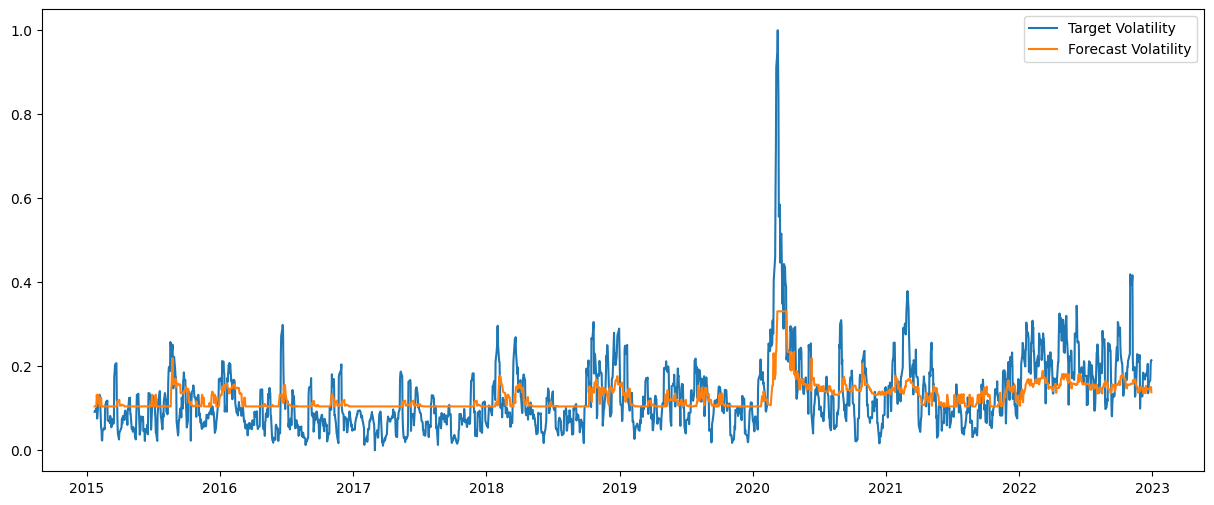

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


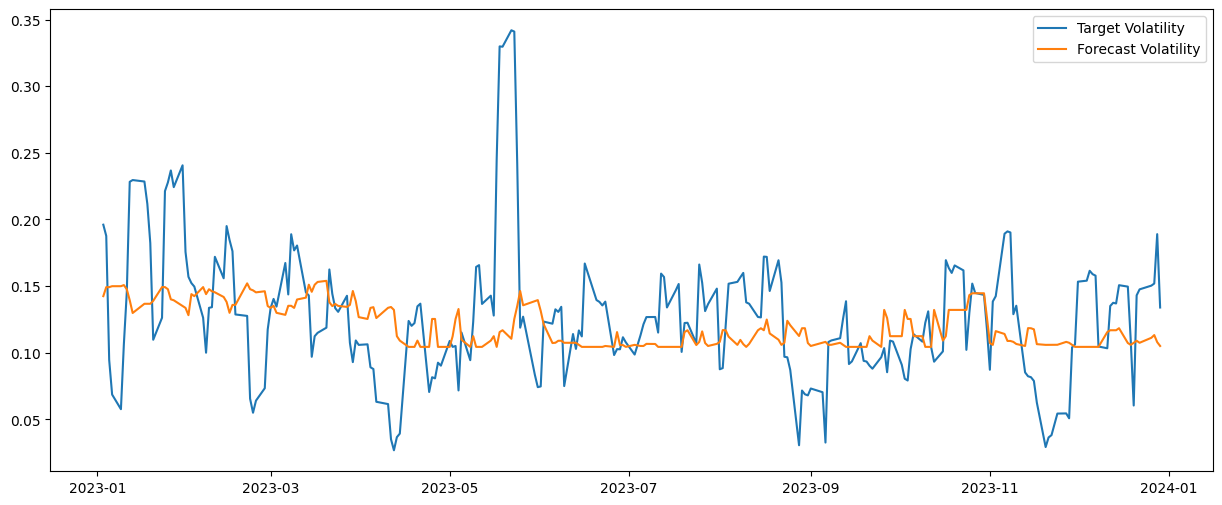

In [457]:
lightgbm_train_performance('SOX RV Lag', True, data_lag)

In [458]:
# Replace the values of 'SOX Weekly_RV' less than 0.0001 with 0.0001 to prevent the log transformation from returning -inf
data.loc[data['VIX'] <= 0.0001, 'VIX'] = 0.0001

# Create new dataframe to store new features for Lof of VIX and Log of past x-day VIX
data_VIX = pd.DataFrame()
data_VIX['VIX Log'] = np.log(data['VIX'])
for i in range(1, 21, 5):
    data_VIX[f'VIX Log {i} Day Mean'] = np.log(data['VIX'].rolling(i).mean())
    data_VIX[f'VIX Log {i} Day Sum'] = np.log(data['VIX'].rolling(i).sum())

data_VIX = data_preprocess_transform(data_VIX.dropna())

[I 2024-04-27 22:06:56,275] A new study created in memory with name: no-name-978c0b6f-a398-47e1-a66f-5fd805fb296c


[I 2024-04-27 22:06:56,602] Trial 0 finished with value: 0.08405559258636501 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.08405559258636501.
[I 2024-04-27 22:06:57,387] Trial 1 finished with value: 0.08420287891612492 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 0 with value: 0.08405559258636501.
[I 2024-04-27 22:06:58,064] Trial 2 finished with value: 0.08620628685492655 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 0 with value: 0.08405559258636501.
[I 2024-04-27 22:06:58,809] Trial 3 finished with value: 0.098996232514

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 16
[LightGBM] [Info] Start training from score 0.127283
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


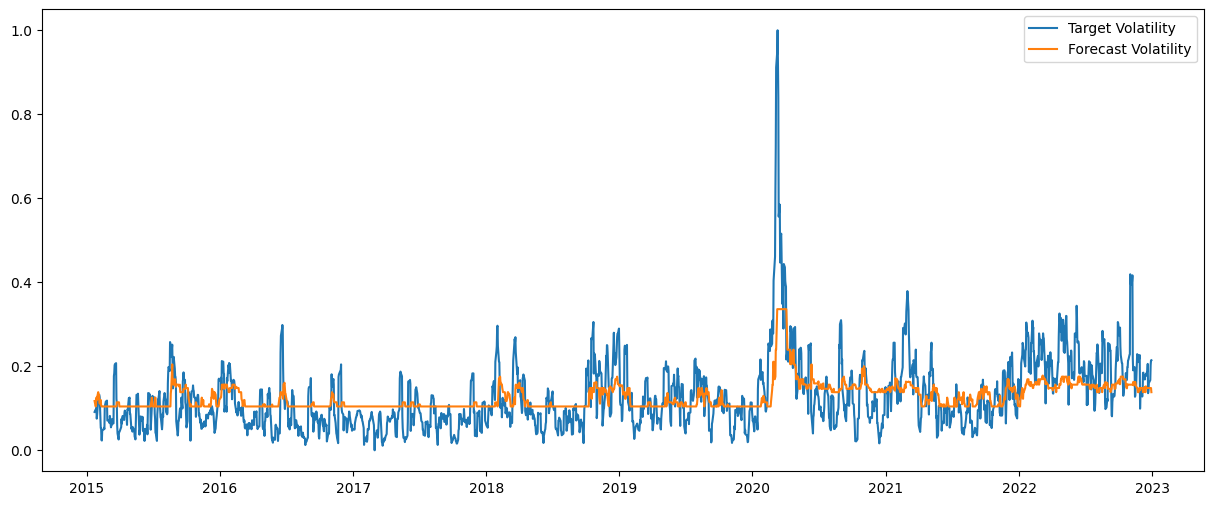

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


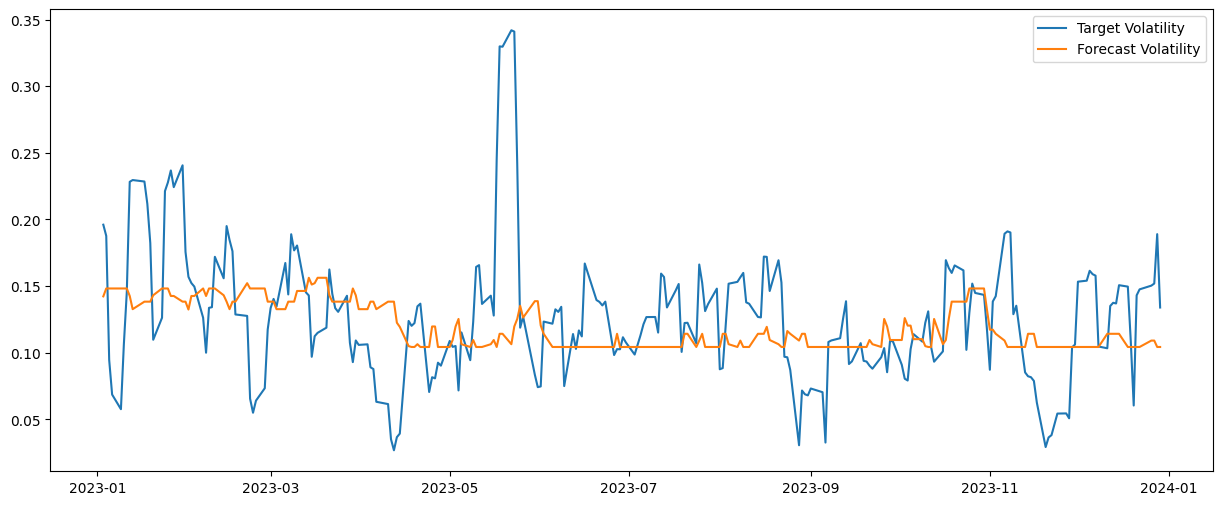

In [459]:
lightgbm_train_performance('VIX Log Value', True, data_VIX)

In [460]:
# Download the ^SOX data from Yahoo Finance (Open, High, Low, Close)
data_spread = yf.download('^SOX', start='2015-01-01', end='2023-12-31', interval='1d')[['Open', 'High', 'Low', 'Close']]
data_spread.index = pd.to_datetime(data_spread.index)

# Calculate the spread between the High and Low prices, open and close prices
data_spread['Spread'] = data_spread['High'] - data_spread['Low']
data_spread['Open_Close_Diff'] = data_spread['Open'] - data_spread['Close']

data_spread

[*********************100%%**********************]  1 of 1 completed
C:\Users\LiaoYF\AppData\Local\Temp\ipykernel_22220\1176219415.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spread['Spread'] = data_spread['High'] - data_spread['Low']


,Open,High,Low,Close,Spread,Open_Close_Diff
Date,,,,,,
2015-01-02,690.280029,694.030029,680.280029,686.729980,13.750000,3.550049
2015-01-05,683.570007,684.840027,673.429993,673.590027,11.410034,9.979980
2015-01-06,675.119995,675.140015,656.369995,658.830017,18.770020,16.289978
2015-01-07,660.419983,668.219971,658.750000,665.270020,9.469971,-4.850037
2015-01-08,671.809998,686.200012,671.809998,684.650024,14.390015,-12.840027
...,...,...,...,...,...,...
2023-12-22,4134.580078,4153.250000,4104.689941,4132.850098,48.560059,1.729980
2023-12-26,4155.729980,4222.319824,4155.200195,4207.450195,67.119629,-51.720215
2023-12-27,4222.240234,4230.930176,4194.959961,4214.589844,35.970215,7.650391


In [461]:
# Add new columns of lag spread and lag open-close difference (14 periods lag)
data_spread_lag = pd.DataFrame()
for i in range(0, 15):
    data_spread_lag[f'Spread Lag {i}'] = data_spread['Spread'].shift(i)
    data_spread_lag[f'Open_Close_Diff Lag {i}'] = data_spread['Open_Close_Diff'].shift(i)

data_spread_lag = data_preprocess_transform(data_spread_lag)
data_spread_lag

,Spread Lag 0,Open_Close_Diff Lag 0,Spread Lag 1,Open_Close_Diff Lag 1,Spread Lag 2,Open_Close_Diff Lag 2,Spread Lag 3,Open_Close_Diff Lag 3,Spread Lag 4,Open_Close_Diff Lag 4,...,Spread Lag 10,Open_Close_Diff Lag 10,Spread Lag 11,Open_Close_Diff Lag 11,Spread Lag 12,Open_Close_Diff Lag 12,Spread Lag 13,Open_Close_Diff Lag 13,Spread Lag 14,Open_Close_Diff Lag 14
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.054665,0.561924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.045363,0.576620,0.054665,0.561924,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,0.074623,0.591041,0.045363,0.576620,0.054665,0.561924,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,0.037649,0.542726,0.074623,0.591041,0.045363,0.576620,0.054665,0.561924,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,0.057210,0.524466,0.037649,0.542726,0.074623,0.591041,0.045363,0.576620,0.054665,0.561924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.193059,0.557765,0.201446,0.498275,0.440901,0.750908,0.115890,0.499348,0.210075,0.577396,...,0.202958,0.487190,0.347673,0.386835,0.339363,0.737492,0.153342,0.519826,0.250308,0.567958
2023-12-26,0.266845,0.435607,0.193059,0.557765,0.201446,0.498275,0.440901,0.750908,0.115890,0.499348,...,0.429889,0.348463,0.202958,0.487190,0.347673,0.386835,0.339363,0.737492,0.153342,0.519826
2023-12-27,0.143006,0.571295,0.266845,0.435607,0.193059,0.557765,0.201446,0.498275,0.440901,0.750908,...,0.199578,0.444863,0.429889,0.348463,0.202958,0.487190,0.347673,0.386835,0.339363,0.737492


[I 2024-04-27 22:07:16,225] A new study created in memory with name: no-name-e065717a-68fb-4860-af18-c50197bcf80b


[I 2024-04-27 22:07:16,622] Trial 0 finished with value: 0.08931259378847779 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.08931259378847779.
[I 2024-04-27 22:07:17,716] Trial 1 finished with value: 0.0819295583630997 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 1 with value: 0.0819295583630997.
[I 2024-04-27 22:07:19,288] Trial 2 finished with value: 0.08483078897846173 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 1 with value: 0.0819295583630997.
[I 2024-04-27 22:07:20,532] Trial 3 finished with value: 0.096757332396208

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9435
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 37
[LightGBM] [Info] Start training from score 0.127283
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


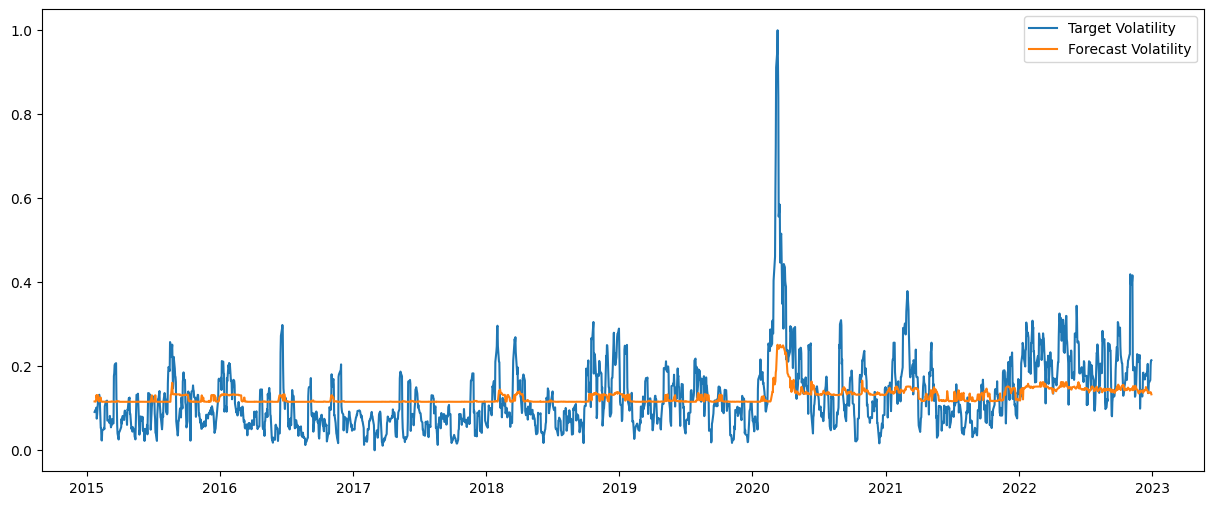

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


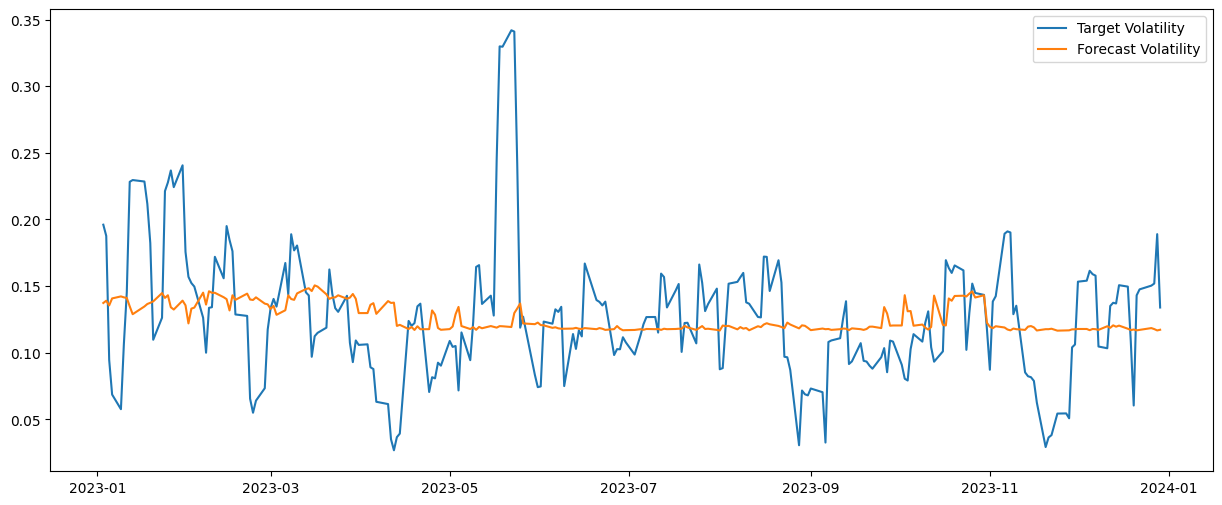

In [462]:
lightgbm_train_performance('SOX Spread', True, data_spread_lag)

              BB_High_5     BB_Low_5      ATR_5   BB_High_10    BB_Low_10  \
Date                                                                        
2015-01-02          NaN          NaN   0.000000          NaN          NaN   
2015-01-05          NaN          NaN   0.000000          NaN          NaN   
2015-01-06          NaN          NaN   0.000000          NaN          NaN   
2015-01-07          NaN          NaN   0.000000          NaN          NaN   
2015-01-08   697.934782   649.693245  15.243994          NaN          NaN   
...                 ...          ...        ...          ...          ...   
2023-12-22  4200.609392  3994.770588  79.006689  4226.833028  3878.454960   
2023-12-26  4261.437439  3975.406604  81.099296  4246.927082  3919.372967   
2023-12-27  4303.755432  3968.700525  72.073480  4254.791353  3968.390678   
2023-12-28  4269.722929  4083.141134  63.268745  4260.329739  4006.398337   
2023-12-29  4256.447181  4119.169030  62.695074  4267.912809  4014.415267   

C:\Users\LiaoYF\AppData\Local\Temp\ipykernel_22220\3337219470.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=6)
C:\Users\LiaoYF\AppData\Local\Temp\ipykernel_22220\3337219470.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=6)
C:\Users\LiaoYF\AppData\Local\Temp\ipykernel_22220\3337219470.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=6)


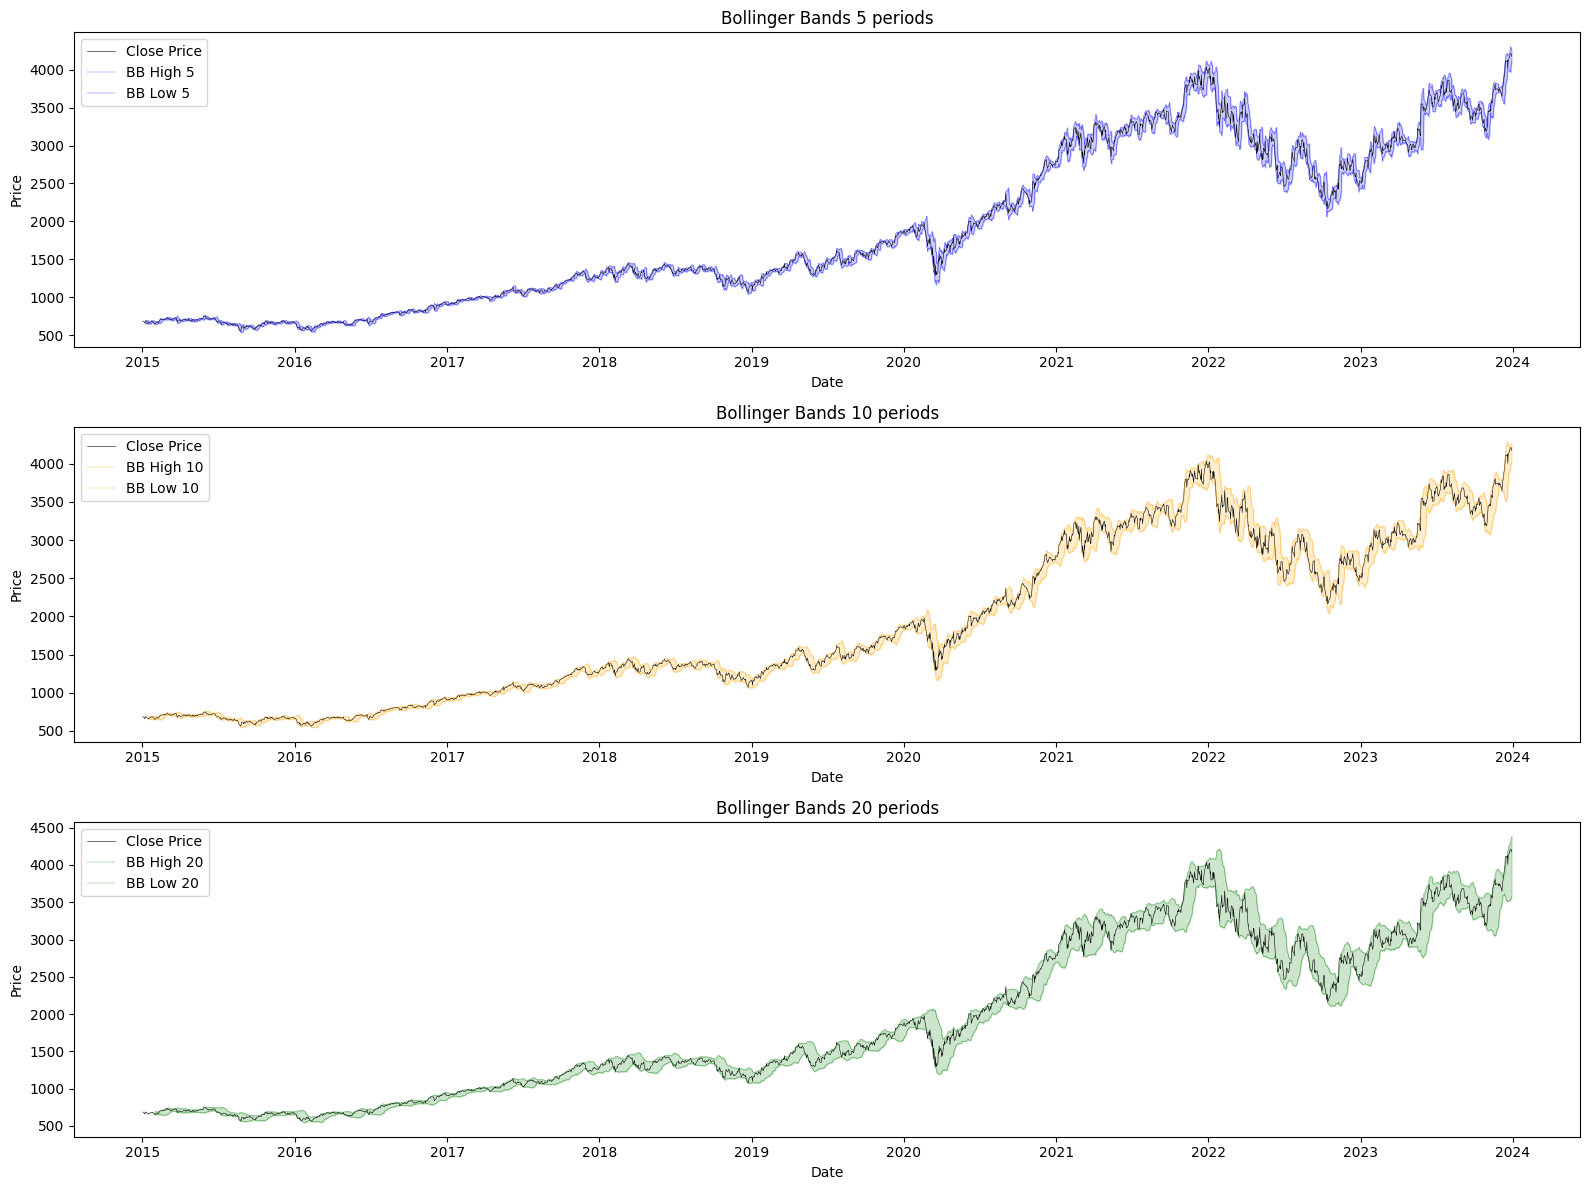

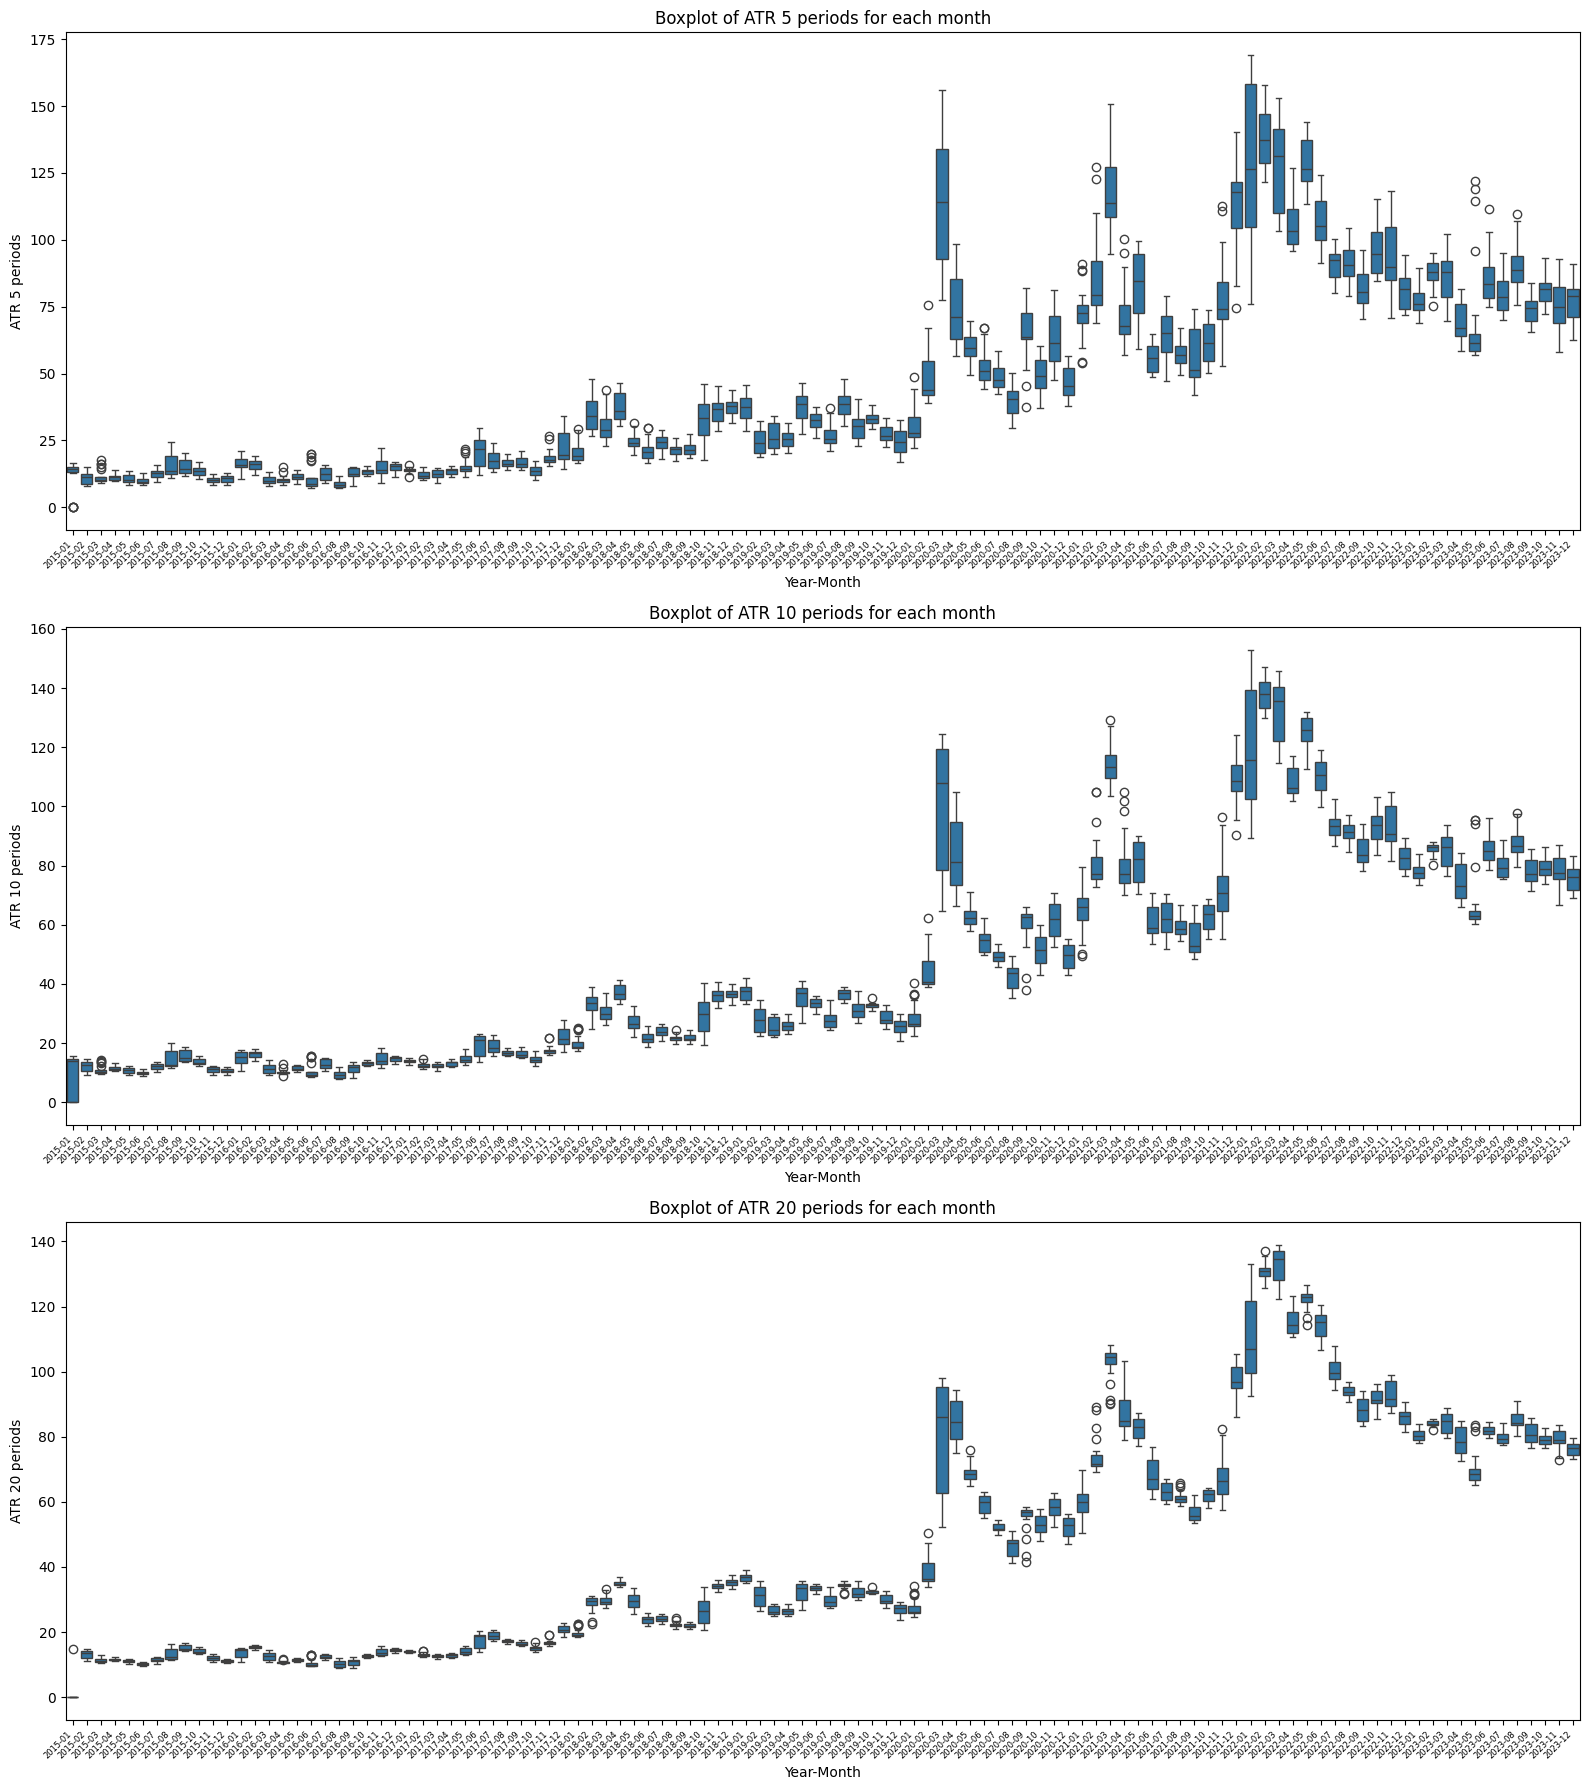

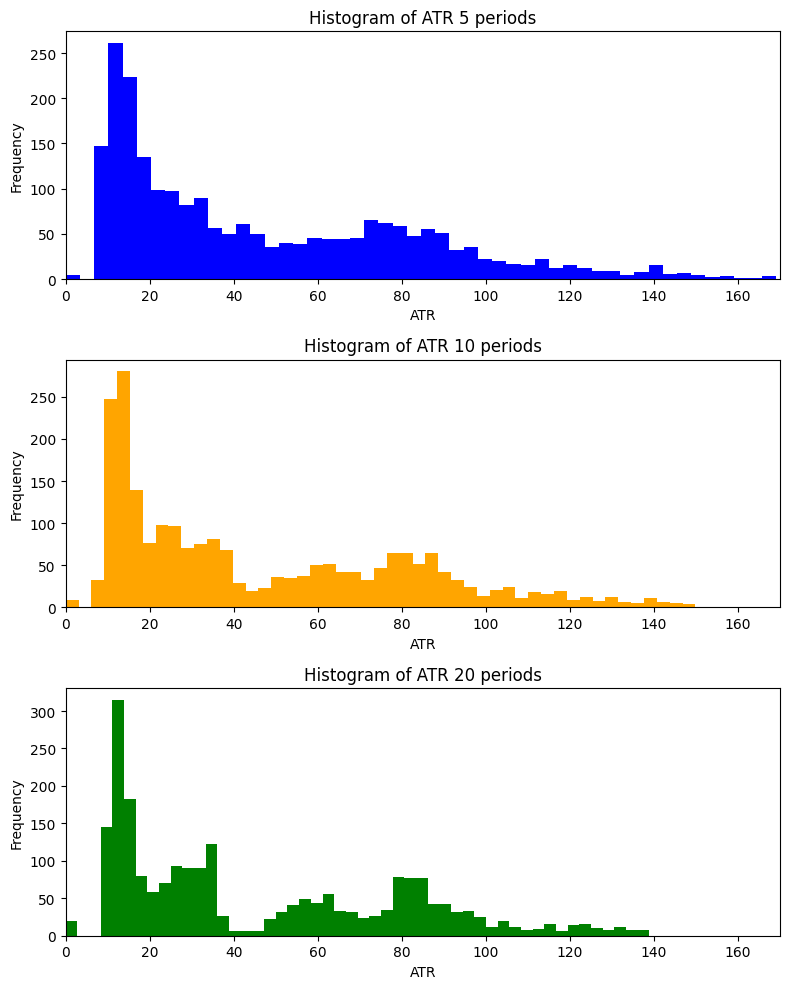

In [463]:
import ta

# Add new columns of Bolllinger Bands (5, 10, 20 periods) and the Average True Range (ATR) (5, 10, 20 periods)
data_ta = pd.DataFrame()
window_list = [5, 10, 20]
for i in range(len(window_list)):
    data_ta[f'BB_High_{window_list[i]}'] = data_spread['Close'].rolling(window_list[i]).mean() + 2 * data_spread['Close'].rolling(window_list[i]).std()
    data_ta[f'BB_Low_{window_list[i]}'] = data_spread['Close'].rolling(window_list[i]).mean() - 2 * data_spread['Close'].rolling(window_list[i]).std()
    data_ta[f'ATR_{window_list[i]}'] = ta.volatility.average_true_range(data_spread['High'], data_spread['Low'], data_spread['Close'], window=window_list[i])

# Plot 3 graph for Bollinger Bands and the Close price
color_list = ['blue', 'orange', 'green']
ax, fig = plt.subplots(3, 1, figsize=(16, 12))
for i in range(len(window_list)):
    fig[i].plot(data_spread['Close'], label='Close Price', linewidth=0.4, color='black')
    fig[i].plot(data_ta[f'BB_High_{window_list[i]}'], label=f'BB High {window_list[i]}', linewidth=0.2, color=color_list[i])
    fig[i].plot(data_ta[f'BB_Low_{window_list[i]}'], label=f'BB Low {window_list[i]}', linewidth=0.2, color=color_list[i])
    fig[i].fill_between(data_ta.index, data_ta[f'BB_Low_{window_list[i]}'], data_ta[f'BB_High_{window_list[i]}'], color=color_list[i], alpha=0.2)
    fig[i].set_title(f'Bollinger Bands {window_list[i]} periods')
    fig[i].set_xlabel('Date')
    fig[i].set_ylabel('Price')
    fig[i].legend()
plt.tight_layout()

# Boxplot for each month of the Average True Range (ATR)
data_ta['Year-Month'] = data_ta.index.strftime('%Y-%m')
print(data_ta)

fig, ax = plt.subplots(3, 1, figsize=(16, 18))
for i in range(len(window_list)):
    sns.boxplot(x='Year-Month', y=f'ATR_{window_list[i]}', data=data_ta, ax=ax[i])
    ax[i].set_title(f'Boxplot of ATR {window_list[i]} periods for each month')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=6)
    ax[i].set_xlabel('Year-Month')
    ax[i].set_ylabel(f'ATR {window_list[i]} periods')
plt.tight_layout()

# 3 histograms for the Average True Range (ATR) for 5, 10, 20 periods
fig, fig = plt.subplots(3, 1, figsize=(8, 10))
for i in range(len(window_list)):
    fig[i].hist(data_ta[f'ATR_{window_list[i]}'], bins=50, color=color_list[i])
    fig[i].set_title(f'Histogram of ATR {window_list[i]} periods')
    fig[i].set_xlim(0, 170)
    fig[i].set_xlabel('ATR')
    fig[i].set_ylabel('Frequency')
plt.tight_layout()

data_ta = data_ta.drop(columns=['Year-Month'])

data_ta = data_preprocess_transform(data_ta.dropna())

[I 2024-04-27 22:07:57,885] A new study created in memory with name: no-name-af803fc5-adf2-4e65-a344-70531da42d58


[I 2024-04-27 22:07:57,986] Trial 0 finished with value: 0.13645702636284068 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.13645702636284068.
[I 2024-04-27 22:07:58,204] Trial 1 finished with value: 0.08573393182350622 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 1 with value: 0.08573393182350622.
[I 2024-04-27 22:07:58,408] Trial 2 finished with value: 0.084662299492863 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 2 with value: 0.084662299492863.
[I 2024-04-27 22:07:58,654] Trial 3 finished with value: 0.1330553558305682

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1995, number of used features: 16
[LightGBM] [Info] Start training from score 0.127371
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


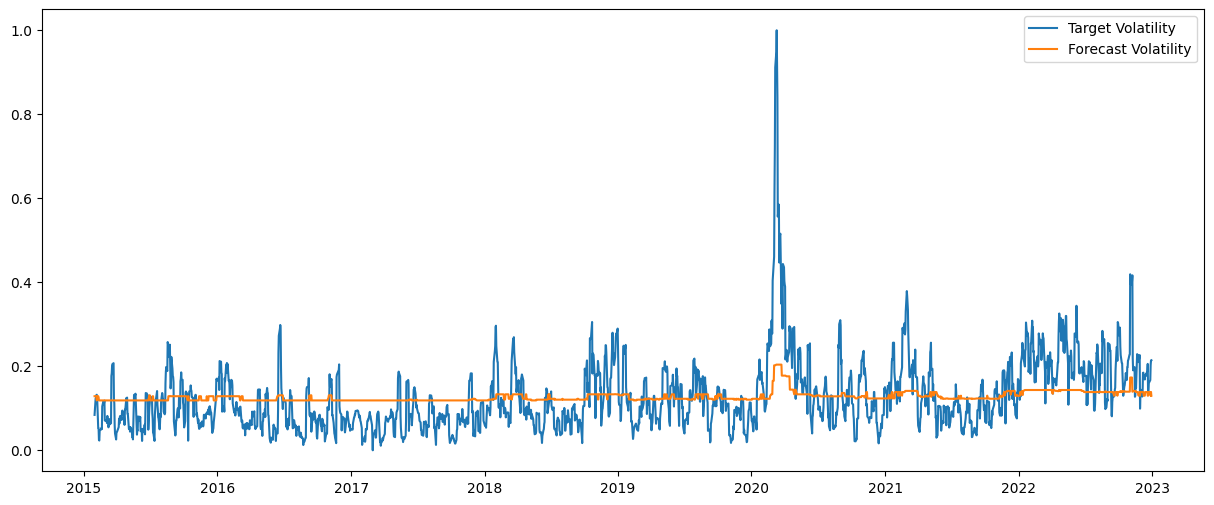

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


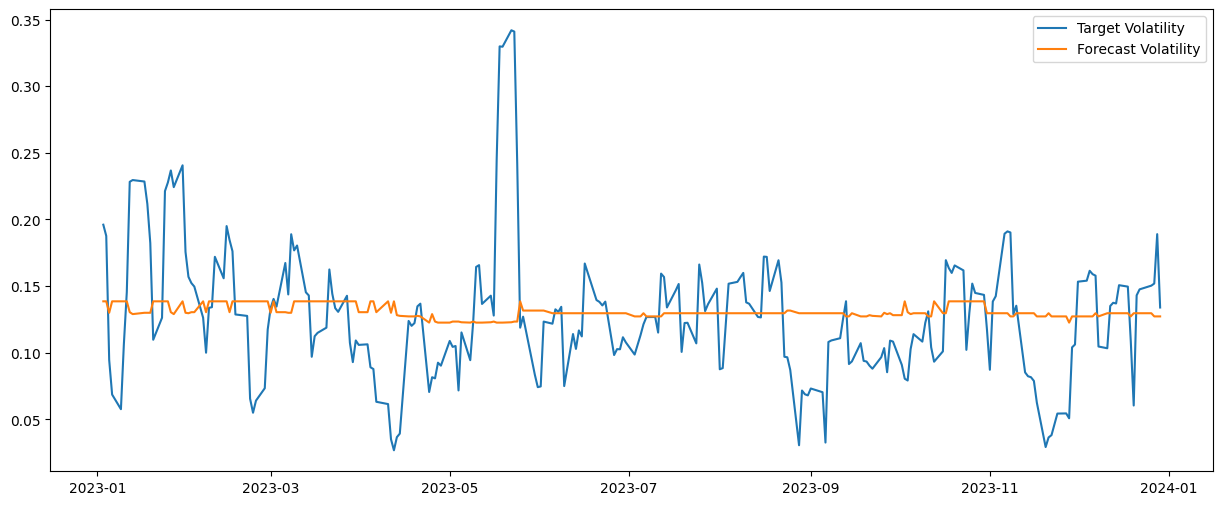

In [464]:
lightgbm_train_performance('TA', True, data_ta)

[I 2024-04-27 22:08:04,929] A new study created in memory with name: no-name-a456bf5a-1f7e-42b9-a693-8c1ed29312ed


[I 2024-04-27 22:08:05,221] Trial 0 finished with value: 0.08461859497037802 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.08461859497037802.
[I 2024-04-27 22:08:05,445] Trial 1 finished with value: 0.08245867536219181 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 1 with value: 0.08245867536219181.
[I 2024-04-27 22:08:05,628] Trial 2 finished with value: 0.08490461230581824 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 1 with value: 0.08245867536219181.
[I 2024-04-27 22:08:05,836] Trial 3 finished with value: 0.093454036695

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2544
[LightGBM] [Info] Number of data points in the train set: 2014, number of used features: 10
[LightGBM] [Info] Start training from score 0.126967
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


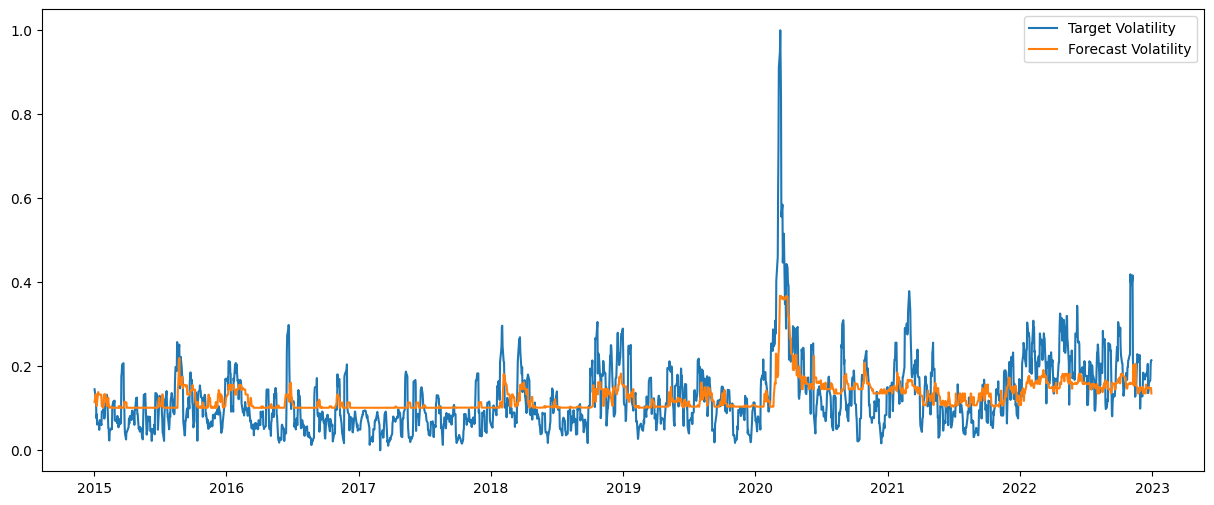

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


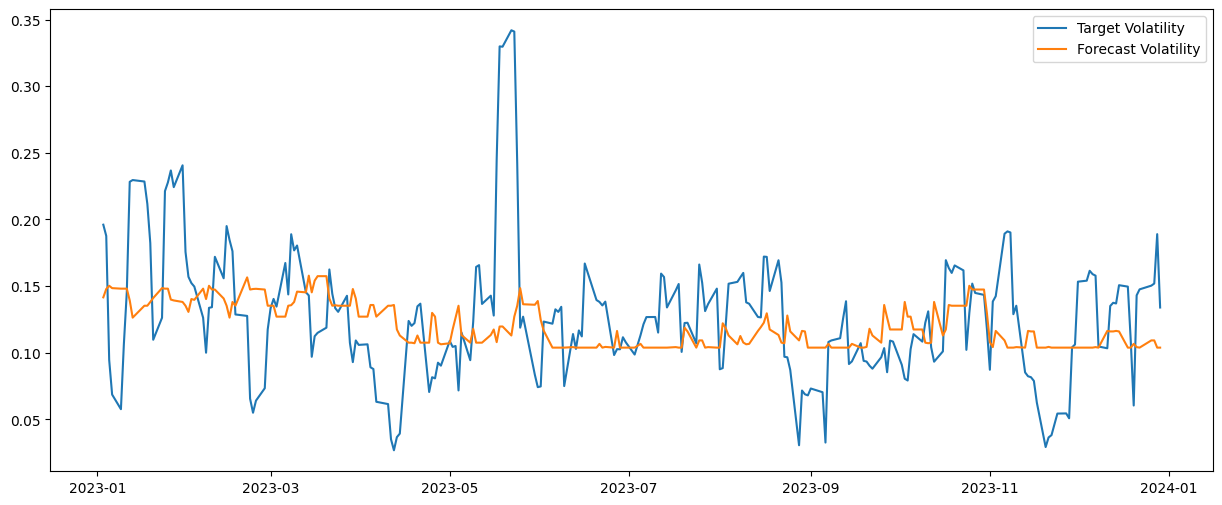

In [465]:
# Load the google trend and sentiment analysis data from the CSV file
data_sentiment = pd.read_csv('new_features_by_date.csv', index_col=0, parse_dates=True)
data_sentiment = data_preprocess_transform(data_sentiment.loc['2015-01-01':'2023-12-31'])
lightgbm_train_performance('Sentiment', True, data_sentiment)

[I 2024-04-27 22:08:12,038] A new study created in memory with name: no-name-06158a92-bd9e-442c-be9c-34e6102b3659


[I 2024-04-27 22:08:12,307] Trial 0 finished with value: 0.1369310870898725 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.1369310870898725.
[I 2024-04-27 22:08:13,192] Trial 1 finished with value: 0.08625226428493435 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 1 with value: 0.08625226428493435.
[I 2024-04-27 22:08:14,312] Trial 2 finished with value: 0.08537021664952235 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 2 with value: 0.08537021664952235.
[I 2024-04-27 22:08:15,707] Trial 3 finished with value: 0.12571605249899

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26259
[LightGBM] [Info] Number of data points in the train set: 1995, number of used features: 103
[LightGBM] [Info] Start training from score 0.127371
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


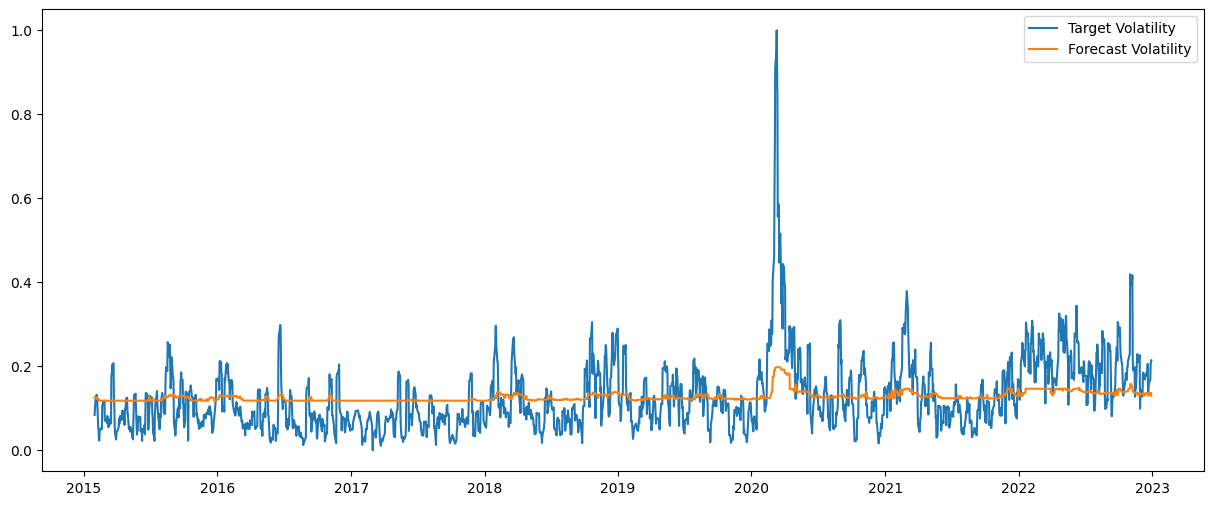

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


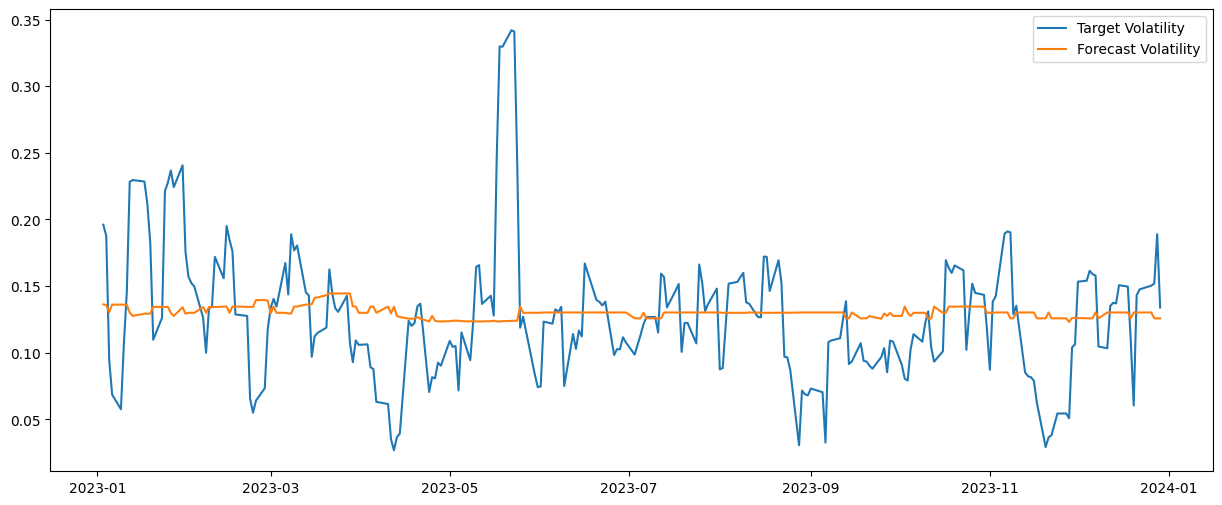

In [466]:
data_all_features = pd.concat([data_lag, data_VIX, data_spread_lag, data_ta, data_sentiment], axis=1)

lightgbm_train_performance('All', True, data_all_features)

### Model Performance Analysis

In [467]:
# Print the model results ordered by the R2 score
model_result.sort_values(by='R2', ascending=False)

,Name,Stydy,Model,RMSE,R2,RMSPE
3,LightGBM_SOX Spread,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.5986653090757...,0.049744,0.009358,0.652236
6,LightGBM_All,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.8450983488948...,0.050441,-0.018592,0.686674
4,LightGBM_TA,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.8547844434078...,0.050523,-0.021892,0.694328
0,LightGBM_Baseline,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.6314588359712...,0.050640,-0.026645,0.620542
5,LightGBM_Sentiment,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.5012015558264...,0.051023,-0.042245,0.617112
1,LightGBM_SOX RV Lag,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.5044150111354...,0.051031,-0.042563,0.616238
2,LightGBM_VIX Log Value,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.5044150111354...,0.051429,-0.058899,0.623839


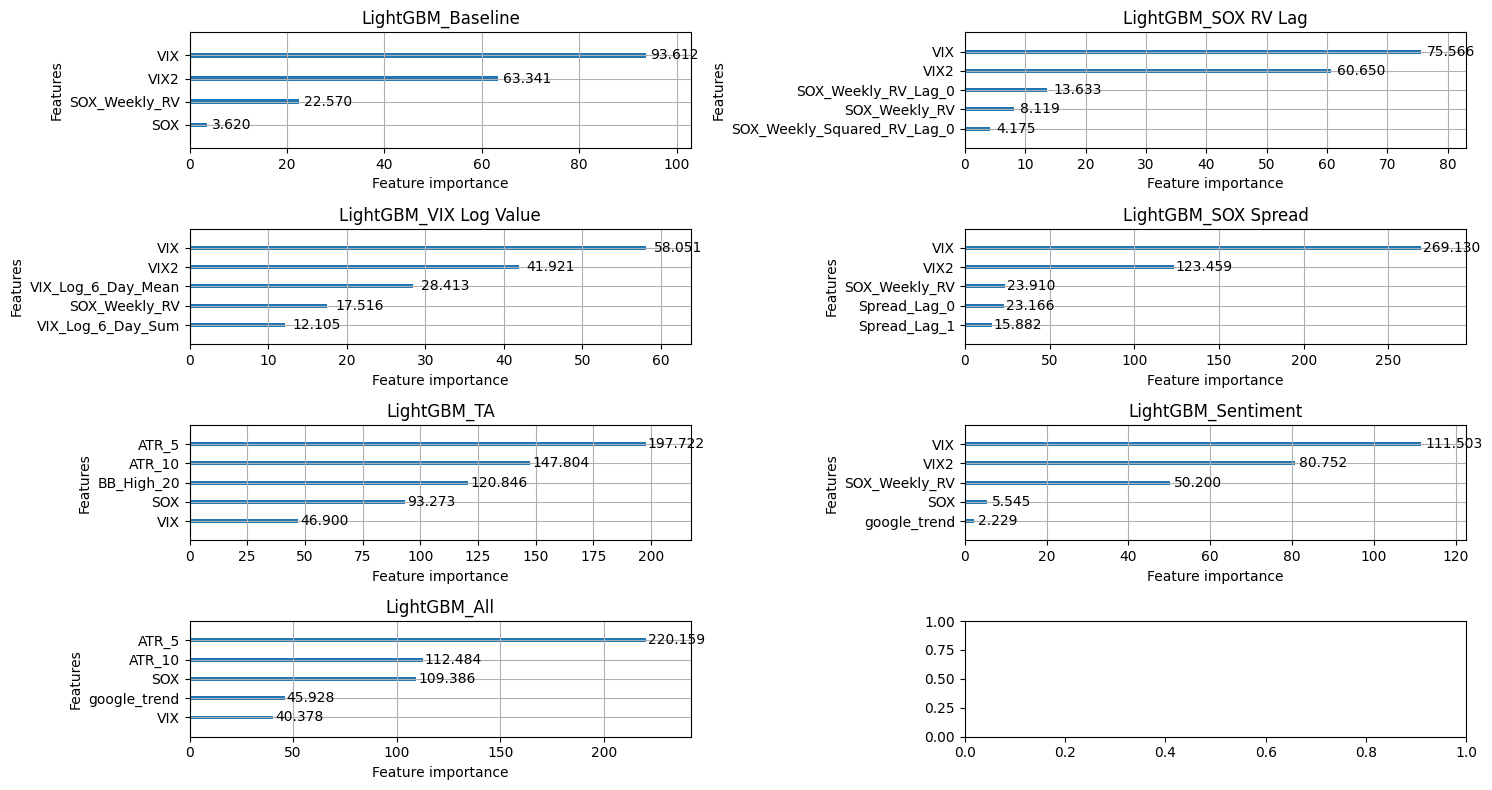

In [469]:
# Plot the feature importance for each model
fig, ax = plt.subplots(4, 2, figsize=(15, 8))
for i in range(4):
    for j in range(2):
        if i*2+j < len(model_result):
            lgb.plot_importance(model_result['Model'][i*2+j], ax=ax[i, j], importance_type='gain', max_num_features=5)
            ax[i, j].set_title(model_result['Name'][i*2+j])
plt.tight_layout()

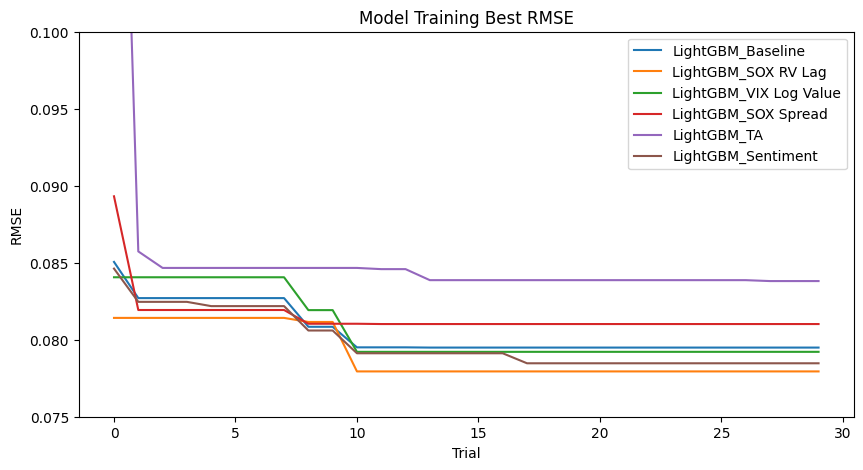

In [473]:
# Plot the min RMSE of each trial for each model
plt.figure(figsize=(10, 5))
for i in range(len(model_result)-1):
    # plot the best value for each trail
    plt.plot(model_result['Stydy'][i].trials_dataframe()['value'].cummin(), label=model_result['Name'][i])
plt.xlabel('Trial')
plt.ylabel('RMSE')
plt.ylim(0.075, 0.1)
plt.title('Model Training Best RMSE')
plt.legend()
plt.show()